In [ ]:
#1- imports

import os

import random
import matplotlib.pyplot as plt

import tensorflow as tf
from skimage.io import imread, imshow
from skimage.transform import resize

import numpy as np
import cv2

In [ ]:
from tensorflow.keras.models import load_model
from keras import backend

In [ ]:
#2- global vaiables

#fix this random variable otherwise model will cause inaurracy
seed = 40
np.random.seed = seed

#global parameters for defining height and width of input image and also number of channels at input
IMAGE_WIDTH_HEIGHT = 128
IMAGE_CHANNELS = 3

#global checks
LOAD_SAVED_MODEL=False

In [ ]:
#3- Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#4- Creates a sorted array of file paths for images and masks

#Training Images 
train_input_dir = '/content/drive/MyDrive/new-seg-2/Training-Data/images'
#Training Masks 
train_mask_dir = '/content/drive/MyDrive/new-seg-2/Training-Data/masks'

#Test Images 
test_input_dir = '/content/drive/MyDrive/new-seg-2/Test-Data/images'
#Test Masks 
test_mask_dir = '/content/drive/MyDrive/new-seg-2/Test-Data/masks'

train_input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)

train_mask_img_paths = sorted(
    [
        os.path.join(train_mask_dir, fname)
        for fname in os.listdir(train_mask_dir)
        if fname.endswith(".png")
    ]
)

test_input_img_paths = sorted(
    [
        os.path.join(test_input_dir, fname)
        for fname in os.listdir(test_input_dir)
        if fname.endswith(".png")
    ]
)

test_mask_img_paths = sorted(
    [
        os.path.join(test_mask_dir, fname)
        for fname in os.listdir(test_mask_dir)
        if fname.endswith(".png")
    ]
)


# print(input_img_paths)
# print(mask_img_paths)
# print(test_input_img_paths)
# print(test_mask_img_paths)

762
762
762
762


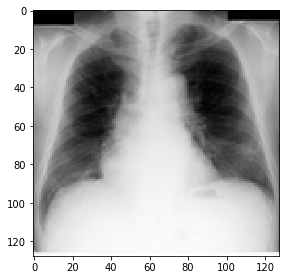

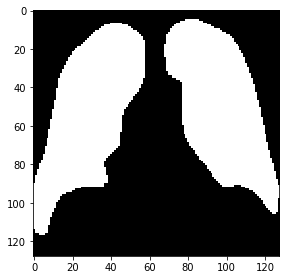

In [ ]:
#5- load images and resize them 128x128 IMAGE_WIDTH_HEIGHT

if LOAD_SAVED_MODEL==False:

  X_train_images = np.zeros((len(train_input_img_paths), IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT, IMAGE_CHANNELS), dtype=np.uint8)
  Y_train_images = np.zeros((len(train_mask_img_paths), IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT, 1), dtype=bool)

  for i in range(len(train_input_img_paths)):
    img = imread(train_input_img_paths[i])[:,:,:IMAGE_CHANNELS]  
    img = resize(img, (IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT), mode='constant', preserve_range=True)
    X_train_images[i] = img 

  mask = np.zeros((IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT, 1), dtype=bool)
  for i in range(len(train_mask_img_paths)):
    mask = imread(train_mask_img_paths[i],as_gray=True,)
    mask = np.expand_dims(resize(mask, (IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT), mode='constant', preserve_range=True), axis=-1)
    Y_train_images[i] = mask

  #for testing train images

  print(len(train_input_img_paths))
  print(len(train_mask_img_paths))

  print(len(X_train_images))
  print(len(Y_train_images))

  rand_number = random.randint(0, len(train_input_img_paths)-1)

  imshow(X_train_images[rand_number])
  plt.show()

  imshow(np.squeeze(Y_train_images[rand_number].astype(float)))
  plt.show()

76
76
76
76


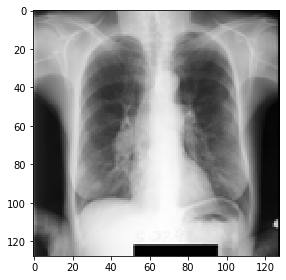

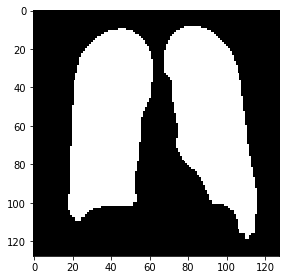

In [ ]:
#5- load images and resize them 128x128 IMAGE_WIDTH_HEIGHT

X_test_images = np.zeros((len(test_input_img_paths), IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT, IMAGE_CHANNELS), dtype=np.uint8)
Y_test_images = np.zeros((len(test_mask_img_paths), IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT, 1), dtype=bool)

for i in range(len(test_input_img_paths)):
  img = imread(test_input_img_paths[i])[:,:,:IMAGE_CHANNELS]  
  img = resize(img, (IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT), mode='constant', preserve_range=True)
  X_test_images[i] = img 

mask = np.zeros((IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT, 1), dtype=bool)
for i in range(len(test_mask_img_paths)):
  mask = imread(test_mask_img_paths[i],as_gray=True,)
  mask = np.expand_dims(resize(mask, (IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT), mode='constant', preserve_range=True), axis=-1)
  Y_test_images[i] = mask

#for testing test images

print(len(test_input_img_paths))
print(len(test_mask_img_paths))

print(len(X_test_images))
print(len(Y_test_images))

rand_number = random.randint(0, len(test_input_img_paths)-1)

imshow(X_test_images[rand_number])
plt.show()

imshow(np.squeeze(Y_test_images[rand_number].astype(float)))
plt.show()

In [ ]:
#6 build the model

if LOAD_SAVED_MODEL==False:

  #create input layer
  inputs_layer = tf.keras.layers.Input((IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT, IMAGE_CHANNELS))
  #as keras layers require floating point values, so we convert each pixel of input image to a number between 0-1 and conv2D expect floats
  s_input = tf.keras.layers.Lambda(lambda x: x / 255)(inputs_layer)

  #** Ecoding **

  #16 filters with each filter size of 3x3. he_normal is used to provide initial weights to the neural network. padding same means keep input and output padding same
  #c1 is result of first convolution
  conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s_input)
  #drop out 10% of values or data from conv1 to avoid overfitting
  conv1 = tf.keras.layers.Dropout(0.1)(conv1)
  #convolution is applied twice at each step
  conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
  #max pooling: downsampling
  pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

  #taking c1 as input
  conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
  conv2 = tf.keras.layers.Dropout(0.1)(conv2)
  conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
  pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
  
  conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
  conv3 = tf.keras.layers.Dropout(0.2)(conv3)
  conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
  pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
  
  conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
  conv4 = tf.keras.layers.Dropout(0.2)(conv4)
  conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
  pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
  
  conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
  conv5 = tf.keras.layers.Dropout(0.3)(conv5)
  conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

  #** Decoding ** 
  #Conv2DTranspose: upsampling
  #stride size means how many pixels to skip while applying filter both horizontally and vertically
  unit6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
  #u6=u6+c4
  unit6 = tf.keras.layers.concatenate([unit6, conv4])
  conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(unit6)
  conv6 = tf.keras.layers.Dropout(0.2)(conv6)
  conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
  
  unit7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
  unit7 = tf.keras.layers.concatenate([unit7, conv3])
  conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(unit7)
  conv7 = tf.keras.layers.Dropout(0.2)(conv7)
  conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
  
  unit8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
  unit8 = tf.keras.layers.concatenate([unit8, conv2])
  conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(unit8)
  conv8 = tf.keras.layers.Dropout(0.1)(conv8)
  conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
  
  unit9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
  unit9 = tf.keras.layers.concatenate([unit9, conv1], axis=3)
  conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(unit9)
  conv9 = tf.keras.layers.Dropout(0.1)(conv9)
  conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
  
  outputs_layer = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)



  #creating unet model
  model = tf.keras.Model(inputs=[inputs_layer], outputs=[outputs_layer])
  #adam tries to reduce loss using backtracking
  #params: weight(connections)+biases(nodes) we are considering accuracy to be displayed at output to measure how well the model is performing
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  # model.summary()

else:
  model = load_model('model/seg_model-save.h5')
  # model.summary()

In [ ]:
if LOAD_SAVED_MODEL==False:

  callbacks = [
          #check point saves our model if something wrong happens during execution. we save our model as seg_model.h5. 
          tf.keras.callbacks.ModelCheckpoint('seg_model.h5', verbose=1, save_best_only=True),
          #monitor val_loss if 2 values (patient) are same then stop execution
          # tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  ]

  #validation size 10%. number of images passed at a time is 16. we pass entire data through model 25 times.
  results = model.fit(X_train_images, Y_train_images, validation_split=0.1, batch_size=20, epochs=25,shuffle=True,verbose=2, callbacks=callbacks)

  model.save('model/seg_model-save.h5')

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.42499, saving model to seg_model.h5
35/35 - 122s - loss: 0.5652 - accuracy: 0.6429 - val_loss: 0.4250 - val_accuracy: 0.6616 - 122s/epoch - 3s/step
Epoch 2/25

Epoch 2: val_loss improved from 0.42499 to 0.35491, saving model to seg_model.h5
35/35 - 117s - loss: 0.4000 - accuracy: 0.7950 - val_loss: 0.3549 - val_accuracy: 0.9208 - 117s/epoch - 3s/step
Epoch 3/25

Epoch 3: val_loss improved from 0.35491 to 0.15026, saving model to seg_model.h5
35/35 - 118s - loss: 0.2259 - accuracy: 0.9291 - val_loss: 0.1503 - val_accuracy: 0.9384 - 118s/epoch - 3s/step
Epoch 4/25

Epoch 4: val_loss improved from 0.15026 to 0.12189, saving model to seg_model.h5
35/35 - 116s - loss: 0.1233 - accuracy: 0.9501 - val_loss: 0.1219 - val_accuracy: 0.9513 - 116s/epoch - 3s/step
Epoch 5/25

Epoch 5: val_loss improved from 0.12189 to 0.11689, saving model to seg_model.h5
35/35 - 116s - loss: 0.1007 - accuracy: 0.9595 - val_loss: 0.1169 - val_accuracy: 0.9540 - 

3/3 [==============================] - 3s 818ms/step
Prediction Image


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


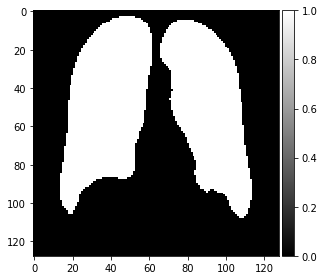

Test Original Image


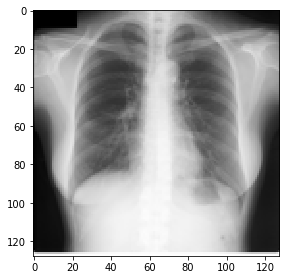

Test Mask Image


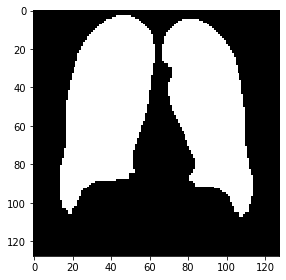

In [ ]:
pred_test = model.predict(X_test_images, verbose=1)

#threasholding predicted values are probabilities from 0-1 so anything above 0.5 take it as foreground else background
pred_test_th = (pred_test > 0.5).astype(np.uint8)

rand_number = random.randint(0, len(pred_test)-1)

#np.squeeze reduces dimensions to (128,128)
print('Prediction Image')
imshow(np.squeeze(pred_test_th[rand_number]), cmap="gray")
plt.show()

print('Test Original Image')
imshow(np.squeeze(X_test_images[rand_number]))
plt.show()

print('Test Mask Image')
imshow(np.squeeze(Y_test_images[rand_number].astype(float)))
plt.show()

**CCA Algorithm**

In [ ]:
def cca(newMatrix):

  label = 0
  obj = 0
  pos = 0
  eq_list = []
  newlist = []
  vset = [1]
  label_matrix = np.zeros((newMatrix.shape[0],newMatrix.shape[1]),dtype=int)

  #Making Label Matrix
  for i in range(1, newMatrix.shape[0]-1):
    for j in range(1, newMatrix.shape[1]-1):
        if newMatrix[i, j] in vset:
            count = 0
            list = []
            if newMatrix[i, j - 1] not in vset and newMatrix[i - 1, j - 1] not in vset and newMatrix[i - 1, j] not in vset and newMatrix[i - 1, j + 1] not in vset:
                label += 1
                label_matrix[i, j] = label
                eq_list.append([label,label])
            if newMatrix[i, j - 1] in vset:
                pos = 1
                count += 1
                list.append(label_matrix[i, j - 1])
            if newMatrix[i - 1, j - 1] in vset:
                pos = 2
                count += 1
                list.append(label_matrix[i - 1, j - 1])
            if newMatrix[i - 1, j] in vset:
                pos = 3
                count += 1
                list.append(label_matrix[i - 1, j])
            if newMatrix[i - 1, j + 1] in vset:
                pos = 4
                count += 1
                list.append(label_matrix[i - 1, j + 1])
            if pos == 1 and count == 1:
                label_matrix[i, j] = label_matrix[i, j - 1]
            if pos == 2 and count == 1:
                label_matrix[i, j] = label_matrix[i - 1, j - 1]
            if pos == 3 and count == 1:
                label_matrix[i, j] = label_matrix[i - 1, j]
            if pos == 4 and count == 1:
                label_matrix[i, j] = label_matrix[i - 1, j + 1]
            if count > 1:
                minimum = min(list)
                for k in range(len(list)):
                    if minimum == list[k]:
                        label_matrix[i,j] = minimum
                    else:
                        label_matrix[i,j] = min(list)
                        #Updating Equivalency list
                        for l in range(len(eq_list)):
                            if eq_list[l][1] > min(list) and eq_list[l][1] in list:
                                eq_list[l][1] = min(list)

  #Updating Label Matrix
  for i in range(1,label_matrix.shape[0]-1):
    for j in range(1,label_matrix.shape[1]-1):
        for k in range(len(eq_list)):
            if label_matrix[i,j] == eq_list[k][0]:
                label_matrix[i,j] = eq_list[k][1]


  new_label_matrix = np.full((label_matrix.shape[0]-2,label_matrix.shape[1]-2),0,np.uint8)
  for i in range(1,label_matrix.shape[0]-1):
    for j in range(1,label_matrix.shape[1]-1):
        new_label_matrix[i-1,j-1] = label_matrix[i,j]

  #Updating no of Objects
  for i in range(new_label_matrix.shape[0]):
    for j in range(new_label_matrix.shape[1]):
        if new_label_matrix[i,j] != 0 and new_label_matrix[i,j] not in newlist:
            minimum = new_label_matrix[i,j]
            newlist.append(minimum)
            obj += 1

  print('Total objects are',obj)
  return obj,new_label_matrix

total_objects,label_matrix = cca(pred_test_th[rand_number])

Total objects are 2


**Erosion Algorithm**

In [ ]:
def erosion(image,structuring_element):
    padding = int(structuring_element.shape[0] / 2)
    image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT,value=0)
    erode_Image_Padded = np.full((image.shape[0], image.shape[1]), 0, np.uint8)
    erode_Image = np.full((erode_Image_Padded.shape[0] - 2*padding, erode_Image_Padded.shape[1] - 2*padding), 0, np.uint8)
    neighbours_Matrix = np.full((structuring_element.shape[0], structuring_element.shape[1]), 0, np.uint8)

    for i in range(padding,image.shape[0]-padding):
        for j in range(padding,image.shape[1]-padding):
            count = 0
            neighbours_Matrix[:,:] = image[i - padding:i + padding+1, j - padding:j + padding+1]
            for k in range(neighbours_Matrix.shape[0]):
                for l in range(neighbours_Matrix.shape[1]):
                    if neighbours_Matrix[k,l] == 1 and structuring_element[k,l] == 1:
                        count += 1
                        count_Matrix_Val = np.count_nonzero(structuring_element == 1)
                        if count == count_Matrix_Val:
                            erode_Image_Padded[i,j] = 1

    for i in range(padding,erode_Image_Padded.shape[0]-padding):
        for j in range(padding,erode_Image_Padded.shape[1]-padding):
            erode_Image[i-padding,j-padding] = erode_Image_Padded[i,j]

    erode_Image = erode_Image.reshape(128,128,-1)
    return erode_Image

if total_objects == 1:
  while total_objects == 1:
    structuring_Element_Size = 3
    structuring_Element = np.full((structuring_Element_Size,structuring_Element_Size),0,np.uint8)

    for i in range(structuring_Element_Size):
      for j in range(structuring_Element_Size):
        structuring_Element[i,j] = 1

    pred_test_th[rand_number] = erosion(pred_test_th[rand_number],structuring_Element)

    imshow(np.squeeze(pred_test_th[rand_number]), cmap="gray")
    plt.show()

    total_objects,label_matrix = cca(pred_test_th[rand_number])

**Dilation Algorithm**

In [ ]:
def dilation(image,structuring_element):
    padding = int(structuring_element.shape[0] / 2)
    image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT,value=0)
    dilated_Image_Padded = np.full((image.shape[0], image.shape[1]), 0, np.uint8)
    dilated_Image = np.full((dilated_Image_Padded.shape[0] - 2*padding, dilated_Image_Padded.shape[1] - 2*padding), 0, np.uint8)
    neighbours_Matrix = np.full((structuring_element.shape[0], structuring_element.shape[1]), 0, np.uint8)

    for i in range(padding,image.shape[0]-padding):
        for j in range(padding,image.shape[1]-padding):
            count = 0
            neighbours_Matrix[:,:] = image[i - padding:i + padding+1, j - padding:j + padding+1]
            for k in range(neighbours_Matrix.shape[0]):
                for l in range(neighbours_Matrix.shape[1]):
                    if neighbours_Matrix[k,l] == 1 and structuring_element[k,l] == 1:
                        dilated_Image_Padded[i,j] = 1

    for i in range(padding,dilated_Image_Padded.shape[0]-padding):
        for j in range(padding,dilated_Image_Padded.shape[1]-padding):
            dilated_Image[i-padding,j-padding] = dilated_Image_Padded[i,j]

    dilated_Image = dilated_Image.reshape(128,128,-1)
    return dilated_Image

if total_objects > 2:
  while total_objects > 2:
    structuring_Element_Size = 3
    structuring_Element = np.full((structuring_Element_Size,structuring_Element_Size),0,np.uint8)

    for i in range(structuring_Element_Size):
      for j in range(structuring_Element_Size):
        structuring_Element[i,j] = 1

    pred_test_th[rand_number] = dilation(pred_test_th[rand_number],structuring_Element)

    imshow(np.squeeze(pred_test_th[rand_number]), cmap="gray")
    plt.show()
  
    total_objects,label_matrix = cca(pred_test_th[rand_number])

**Separating both lungs from each other**

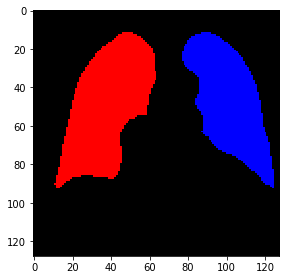

In [ ]:
def separate_Lungs(original_Image,label_Matrix):

  new_Matrix = np.full((original_Image.shape[0],original_Image.shape[1],3),0,np.uint8)

  for i in range(label_Matrix.shape[0]):
    for j in range(label_Matrix.shape[1]):
      if label_matrix[i,j] == 1:
        new_Matrix[i,j] = (255,0,0)
      elif label_matrix[i,j] == 2:
        new_Matrix[i,j] = (0,0,255)

  return new_Matrix

separated_Image = separate_Lungs(pred_test_th[rand_number],label_matrix)
imshow(np.squeeze(separated_Image), cmap="gray")
plt.show()

(128, 128, 1)
(128, 128, 1)
F1 Score = 0.9821274876594543
Prediction Image


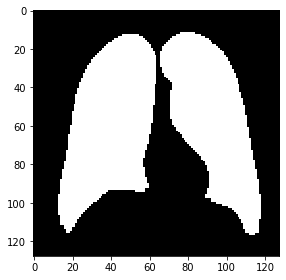

Test Mask Image


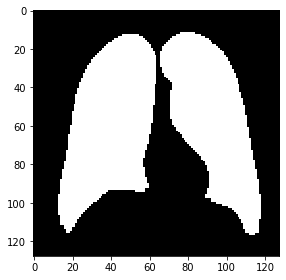

In [ ]:
def calculator_f1(Y_Pred,Y_True):
    print(Y_Pred.shape)
    print(Y_True.shape)

    Y_Pred_float = tf.reshape(tf.dtypes.cast(Y_Pred, tf.float32), [-1])
    Y_True_float = tf.reshape(tf.dtypes.cast(Y_True, tf.float32), [-1])

    intersection = tf.reduce_sum(Y_Pred_float * Y_True_float)
    union=tf.reduce_sum(Y_Pred_float) + tf.reduce_sum(Y_True_float)

    smooth=1.

    return (2. * intersection + smooth) / (union + smooth)

rand_number = random.randint(0, len(test_input_img_paths)-1)

# Y_Pred = Y_test_images[rand_number]/255.
# Y_True = Y_test_images[rand_number]/255.

#/255 gives inaccurate results
Y_Pred = pred_test_th[rand_number]
Y_True = Y_test_images[rand_number]

# Y_True = Y_test_images[70]/255.
# Y_Pred = pred_test_th[70]/255.

score = calculator_f1(Y_Pred, Y_True)

print ("F1 Score = {}".format(score))

print('Prediction Image')
imshow(np.squeeze(Y_test_images[rand_number].astype(float)))
plt.show()

print('Test Mask Image')
imshow(np.squeeze(Y_test_images[rand_number].astype(float)))
plt.show()

#Note: the problem was with mask that we are taking boolean image as input with 1's and 0's which are true and false and grey image has 0-255 range this code is made for gray scale, so we first have to convert boolean to gray scale